# Projeto 1 - Classificação utilizando Multi-Layer Perceptrons (MLP)

Prazo de entrega: 05/10/2025

O enunciado do projeto está disponível no [link](https://insper.github.io/ann-dl/versions/2025.2/projects/classification).

Integrantes:
- Carlos Eduardo P. Yamada

- Pedro De Lucca S. C. Ferro

___

## Import de bibliotecas

Aqui, são importadas bibliotecas necessárias para realização do treinamento de um modelo de classificação utilizando MLP com `sklearn`. Também são importadas outras bibliotecas para auxiliar no desenvolvimento do projeto.

In [99]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

___

## Seleção do *dataset*

A base de dados escolhida para trabalho pode ser encontrada no [link](https://www.kaggle.com/datasets/ahmeduzaki/earthquake-alert-prediction-dataset?resource=download). É importante apontar que os dados nesse *dataset* já foram **tratados** previamente, e que os dados originais se encontram no seguinte [link](https://www.kaggle.com/datasets/warcoder/earthquake-dataset).

In [100]:
BALANCED_DATA_PATH = "./data/earthquake_alert_balanced_dataset.csv"
UNBALANCED_DATA_PATH = "./data/earthquake_data.csv"

In [101]:
balanced_data = pd.read_csv(BALANCED_DATA_PATH)
unbalanced_data = pd.read_csv(UNBALANCED_DATA_PATH)

In [102]:
balanced_counts = balanced_data["alert"].value_counts(normalize=True) * 100
unbalanced_counts = unbalanced_data["alert"].value_counts(normalize=True) * 100

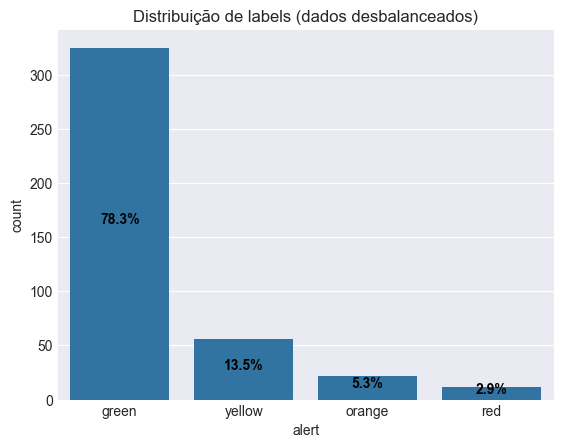

In [103]:
sns.countplot(x="alert", data=unbalanced_data)

for i, v in enumerate(unbalanced_counts):
    plt.text(i, unbalanced_data["alert"].value_counts().iloc[i] / 2, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

plt.title("Distribuição de labels (dados desbalanceados)")
plt.show()

Como pode ser observado, os dados no *dataset* original estão **desbalanceados**, sendo cerca de $80\%$ dos eventos registrados rotulados como alerta do tipo verde. Para resolver esse problema, foi utilizado o *Syntethic Minority Oversampling Technique* (SMOTE). Com isso, o tamanho da amostragem também passou de $782$ para $1300$, e dados inválidos também foram tratados. O autor do *dataset* tratado realizou esse procedimento e documentou o uso desse método na página do Kaggle.

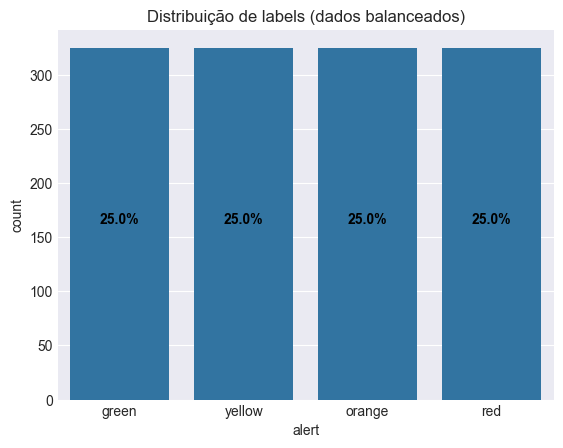

In [104]:
sns.countplot(x="alert", data=balanced_data)

for i, v in enumerate(balanced_counts):
    plt.text(i, balanced_data["alert"].value_counts().iloc[i] / 2, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

plt.title("Distribuição de labels (dados balanceados)")
plt.show()

O histograma na célula acima apresenta a distribuição de *labels* **após** o *oversampling*. Como pode ser observado, os dados estão balanceados igualmente entre si.

## Sobre o *dataset*

O *dataset* tem como propósito fornecer informações para avaliar riscos e previsão de alertas de terremotos. Os dados disponíveis dizem respeito à informações sobre registros de terremotos como magnitude, intensidade sentida pela população etc. As features são listadas na tabela abaixo.

| Coluna      | Tipo                  | Descrição                                                                               |
|-------------|-----------------------|-----------------------------------------------------------------------------------------|
| `magnitude` | Numérico (`float`)    | Medida da energia liberada pelo terremoto na escala Richter.                            |
| `depth`     | Numérico (`float`)    | Profundidade do epicentro em quilômetros.                                               |
| `cdi`       | Numérico (`float`)    | *Community Decimal Intensity* – intensidade sentida pela população (escala de 1 a 10).  |
| `mmi`       | Numérico (`float`)    | *Modified Mercalli Intensity* – intensidade dos danos observados (escala de 1 a 10).    |
| `sig`       | Numérico (`float`)    | Significância do evento (pontuação calculada pelo USGS).                                |
| `alert`     | Categórica (`string`) | *Target*: nível de alerta — `green`, `yellow`, `orange`, ou `red`.                      |

Obs.: o CDI é uma medida baseada em relatos da população, que se aproxima do MMI, que por sua vez é determinado com base em observações técnicas ou relatos consolidados. Um valor na escala CDI de por exemplo, $7.0$, equivale a MMI 7 ou MMI VII (é comumente mostrado com algarismos romanos).

Os gráficos mostrados a seguir mostram como os dados estão distribuídos em relação à quantidade total de dados.

In [105]:
df = balanced_data.copy()

numeric_df = df.select_dtypes(include=["float64", "int64"])
corr = numeric_df.corr()

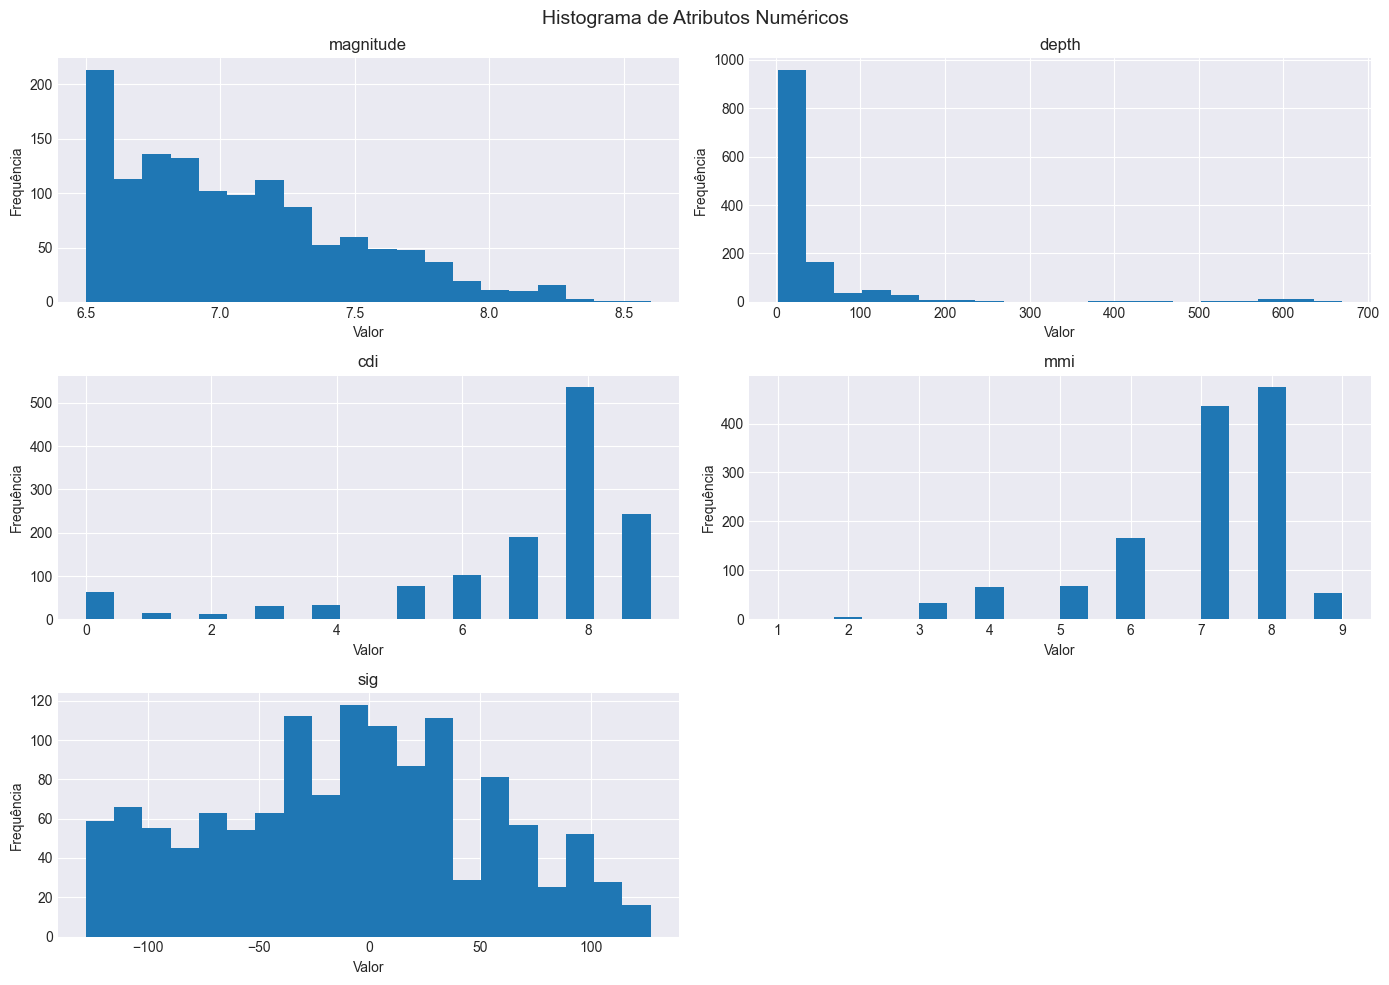

In [106]:
numeric_df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Histograma de Atributos Numéricos", fontsize=14)
for ax in plt.gcf().get_axes():
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()

Em sequência, temos a correlação das features entre si, mostradas em forma de uma matriz.

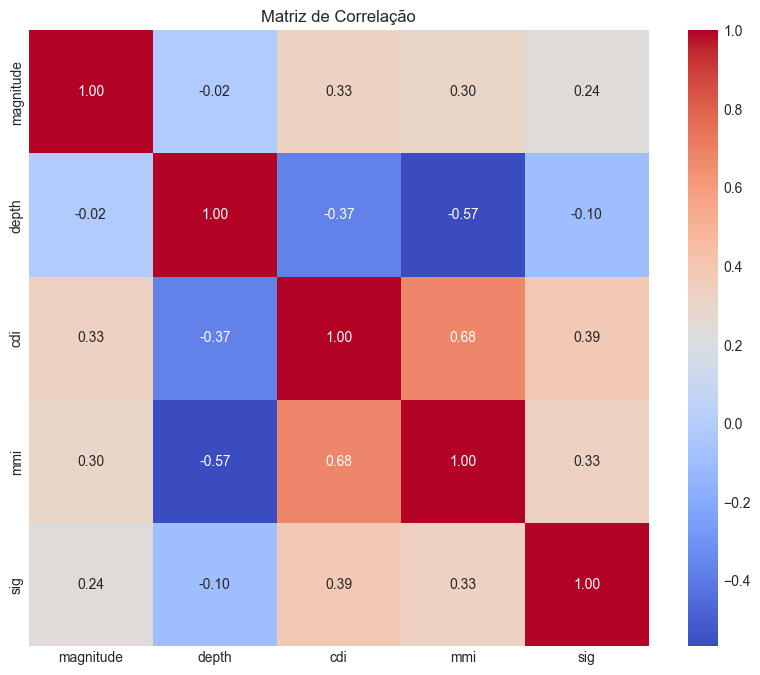

In [107]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

___
## Pré-processamento

Antes de realizar o treinamento do modelo, precisou ser feita a normalização das colunas numéricas do *dataset* e *one-hot encoding* da coluna de *labels*.

### *One-hot Encoding*

In [108]:
encoded = pd.get_dummies(df["alert"], prefix="alert", dtype=int)
df = df.drop(columns=["alert"])
df = pd.concat([df, encoded], axis=1)

### Padronização com *z-score*

In [109]:
df["z_magnitude"] = df["magnitude"].apply(lambda x: (x - df["magnitude"].mean()) / df["magnitude"].std())
df["z_depth"] = df["depth"].apply(lambda x: (x - df["depth"].mean()) / df["depth"].std())
df["z_cdi"] = df["cdi"].apply(lambda x: (x - df["cdi"].mean()) / df["cdi"].std())
df["z_mmi"] = df["mmi"].apply(lambda x: (x - df["mmi"].mean()) / df["mmi"].std())
df["z_sig"] = df["sig"].apply(lambda x: (x - df["sig"].mean()) / df["sig"].std())

### Embaralhamento das amostras

Para evitar *overfitting* do modelo, as amostras foram embaralhadas. Isso garante que o modelo não será treinado de forma enviesada.

In [110]:
X, y = df[["z_magnitude", "z_depth", "z_cdi", "z_mmi", "z_sig"]], df[["alert_green", "alert_orange", "alert_red", "alert_yellow"]]
X, y = shuffle(X, y, random_state=42)

In [111]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

## MLP

Além disso, foram utilizadas 4 camadas ocultas. Foram realizados testes para 16, 32 e 64 neurônios em cada uma delas, como pode ser visto no código a seguir, a fim de avaliar a qualidade e o tempo de execução do treinamento do modelo.

Para todos os casos, utilizamos o otimizador Adam devido à estabilidade que ele oferece ao longo do treinamento. Outra alternativa seria utilizar o Gradient Descent padrão, devido ao tamanho do dataset (1300 amostras, relativamente pequeno quando comparado a outros como Fashion MNIST ou ao dataset de diabetes) e também pela estabilidade.

### Divisão do *dataset*

A divisão do *dataset* em treino e teste (*train/test split*) foi feita em uma proporção de $70\%$ para $30\%$. No código, foi utilizado `random_state=42` para garantir reprodutibilidade.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Treinamento do modelo

Para treinamento do modelo, foi fixado um número de 4 camadas ocultas, cada uma com um número igual de neurônios. A fim de verificar a performance com diferentes parâmetros, foram feitos 3 modelos, cada um com uma diferente quantidade de neurônios (16, 32 e 64 neurônios em cada camada, respectivamente).

In [113]:
hidden_layer_format_16 = (
    16,
    16,
    16,
    16,
)

hidden_layer_format_32 = (
    32,
    32,
    32,
    32,
)

hidden_layer_format_64 = (
    64,
    64,
    64,
    64,
)


In [114]:
clf16 = MLPClassifier(hidden_layer_sizes=hidden_layer_format_16,
                      max_iter=1000,
                      random_state=42,
                      learning_rate_init=0.01,
                      batch_size=100,
                      solver="adam",
                      warm_start=True)

clf32 = MLPClassifier(hidden_layer_sizes=hidden_layer_format_32,
                      max_iter=1000,
                      random_state=42,
                      learning_rate_init=0.01,
                      batch_size=100,
                      solver="adam",
                      warm_start=True)

clf64 = MLPClassifier(hidden_layer_sizes=hidden_layer_format_64,
                      max_iter=1000,
                      random_state=42,
                      learning_rate_init=0.01,
                      batch_size=100,
                      solver="adam",
                      warm_start=True)


In [115]:
clfs_info = {
    16: {
        "clf": clf16,
        "train_accuracy": [],
        "test_accuracy": [],
        "runtime": 0.0
    },
    32: {
        "clf": clf32,
        "train_accuracy": [],
        "test_accuracy": [],
        "runtime": 0.0
    },
    64: {
        "clf": clf64,
        "train_accuracy": [],
        "test_accuracy": [],
        "runtime": 0.0
    }
}

Para cada modelo, foi medido o tempo de execução para avaliar as diferenças entre eles.

In [116]:
for n_neurons, info in clfs_info.items():
    start = time.perf_counter()

    for i in range(1000):
        info["clf"].fit(X_train, y_train)
        y_train_pred = info["clf"].predict(X_train)
        y_val_pred = info["clf"].predict(X_test)
        info["train_accuracy"].append(accuracy_score(y_train, y_train_pred))
        info["test_accuracy"].append(accuracy_score(y_test, y_val_pred))
        
    end = time.perf_counter()

    info["runtime"] = end - start
    print(f"Tempo de execução para 4 camadas com {n_neurons} neurônios em cada camada: {end - start:.4f}s")

Tempo de execução para 4 camadas com 16 neurônios em cada camada: 16.7565s
Tempo de execução para 4 camadas com 32 neurônios em cada camada: 22.4155s
Tempo de execução para 4 camadas com 64 neurônios em cada camada: 28.1982s


### Avaliação dos modelos

Através de gráficos da acurácia e perda ao longo do treinamento, matrizes de confusão para comparar os dados preditos com os dados verdadeiros e outras métricas como *F1-Score*, *recall* e precisão, podemos verificar a qualidade dos modelos de acordo com a quantidade de neurônios.

In [117]:
y_test_labels = y_test.idxmax(axis=1).str.replace('alert_', '')
y_pred_labels = {
    16: pd.DataFrame(clfs_info[16]["clf"].predict(X_test), columns=y_test.columns).idxmax(axis=1).str.replace('alert_', ''), 
    32: pd.DataFrame(clfs_info[32]["clf"].predict(X_test), columns=y_test.columns).idxmax(axis=1).str.replace('alert_', ''),
    64: pd.DataFrame(clfs_info[64]["clf"].predict(X_test), columns=y_test.columns).idxmax(axis=1).str.replace('alert_', '')
}
labels = ['green', 'yellow', 'orange', 'red']

#### Acurácia

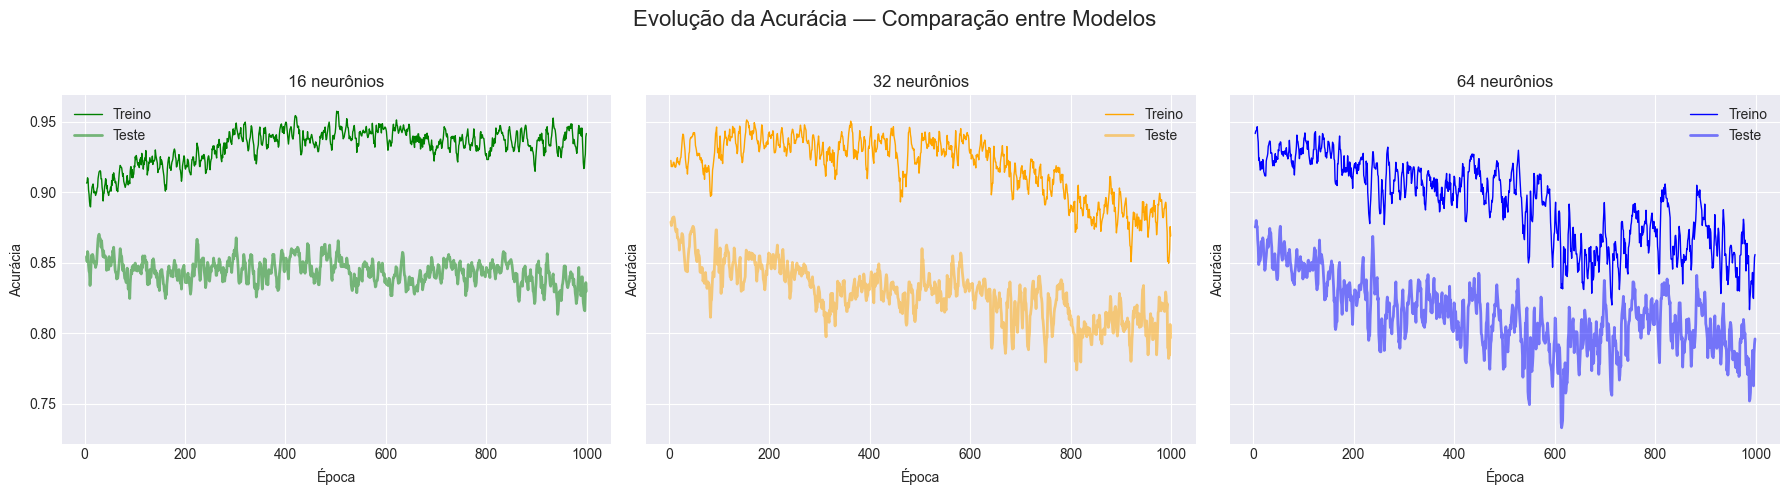

In [118]:
plt.style.use('seaborn-v0_8-darkgrid')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, model, cor in zip(axes, clfs_info.keys(), ['g', 'orange', 'b']):
    train_smooth = pd.Series(clfs_info[model]["train_accuracy"]).rolling(5).mean()
    test_smooth = pd.Series(clfs_info[model]["test_accuracy"]).rolling(5).mean()

    ax.plot(train_smooth, color=cor, linewidth=1, label='Treino')
    ax.plot(test_smooth, color=cor, linewidth=2, alpha=0.5, label='Teste')

    ax.set_title(f'{model} neurônios')
    ax.set_xlabel('Época')
    ax.set_ylabel('Acurácia')
    ax.legend()

fig.suptitle("Evolução da Acurácia — Comparação entre Modelos", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Perda (*loss*)

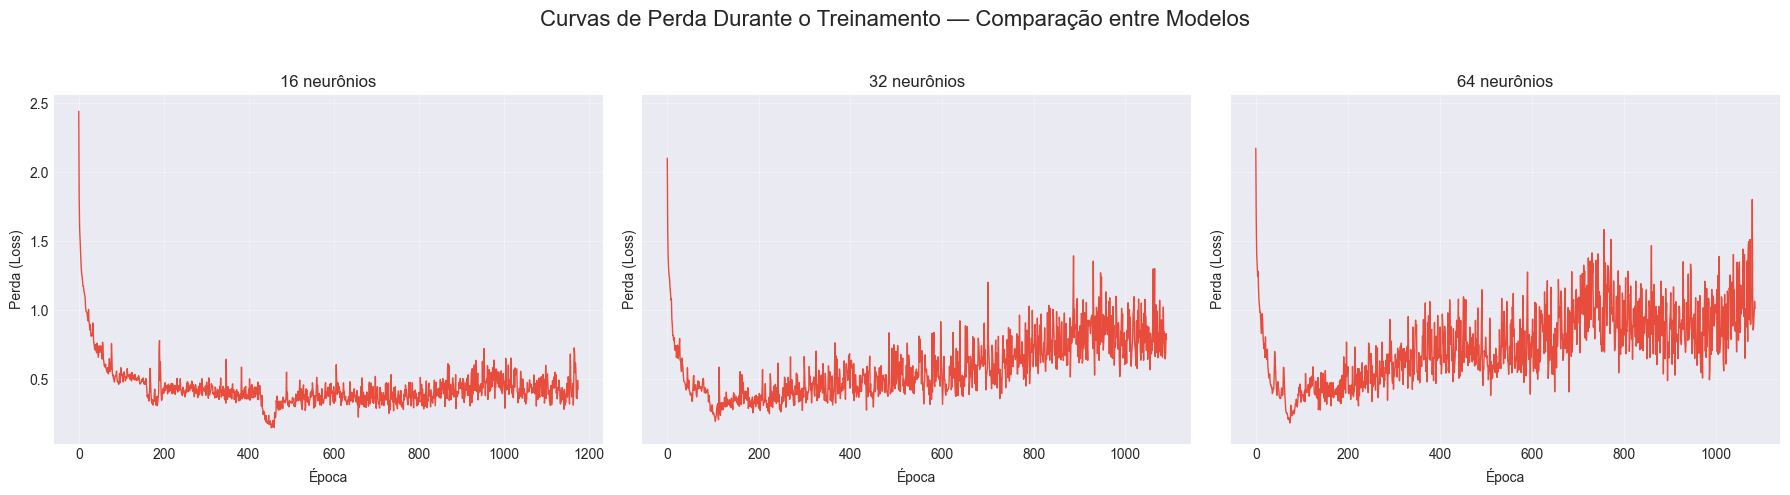

In [119]:
plt.style.use('seaborn-v0_8-darkgrid')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (neurons, info) in zip(axes, clfs_info.items()):
    loss_curve = info['clf'].loss_curve_

    ax.plot(loss_curve, color='#e74c3c', linewidth=1)
    ax.set_title(f'{neurons} neurônios')
    ax.set_xlabel('Época')
    ax.set_ylabel('Perda (Loss)')
    ax.grid(True, alpha=0.3)

fig.suptitle('Curvas de Perda Durante o Treinamento — Comparação entre Modelos', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Avaliação de *overfitting*

In [120]:
for neurons, info in clfs_info.items():
    print("=" * 70)
    print(f"Métricas de performance do modelo com {neurons} neurônios")
    print("=" * 70)
    print(f"Acurácia no conjunto de TREINO: {info['train_accuracy'][-1]:.4f} ({info['train_accuracy'][-1]*100:.2f}%)")
    print(f"Acurácia no conjunto de TESTE: {info['test_accuracy'][-1]:.4f} ({info['test_accuracy'][-1]*100:.2f}%)")
    print(f"\nDiferença (overfitting): {(info['train_accuracy'][-1] - info['test_accuracy'][-1])*100:.2f}%")
    print("=" * 70)
    print()

Métricas de performance do modelo com 16 neurônios
Acurácia no conjunto de TREINO: 0.9363 (93.63%)
Acurácia no conjunto de TESTE: 0.8026 (80.26%)

Diferença (overfitting): 13.37%

Métricas de performance do modelo com 32 neurônios
Acurácia no conjunto de TREINO: 0.8659 (86.59%)
Acurácia no conjunto de TESTE: 0.7923 (79.23%)

Diferença (overfitting): 7.36%

Métricas de performance do modelo com 64 neurônios
Acurácia no conjunto de TREINO: 0.8802 (88.02%)
Acurácia no conjunto de TESTE: 0.8154 (81.54%)

Diferença (overfitting): 6.48%



#### *F1-Score*, *recall*, precisão com `classification_report()`

In [121]:
for neurons, y_pred in y_pred_labels.items():
    print(f"Relatório de classificação para {neurons} neurônios")
    print("=" * 70)
    print(classification_report(y_test_labels, y_pred, target_names=['green', 'orange', 'red', 'yellow']))

Relatório de classificação para 16 neurônios
              precision    recall  f1-score   support

       green       0.73      0.88      0.80        97
      orange       0.84      0.82      0.83        98
         red       0.90      0.85      0.87        97
      yellow       0.80      0.71      0.75        98

    accuracy                           0.81       390
   macro avg       0.82      0.81      0.81       390
weighted avg       0.82      0.81      0.81       390

Relatório de classificação para 32 neurônios
              precision    recall  f1-score   support

       green       0.78      0.89      0.83        97
      orange       0.77      0.84      0.80        98
         red       0.85      0.94      0.89        97
      yellow       0.88      0.59      0.71        98

    accuracy                           0.81       390
   macro avg       0.82      0.81      0.81       390
weighted avg       0.82      0.81      0.81       390

Relatório de classificação para 64 neurô

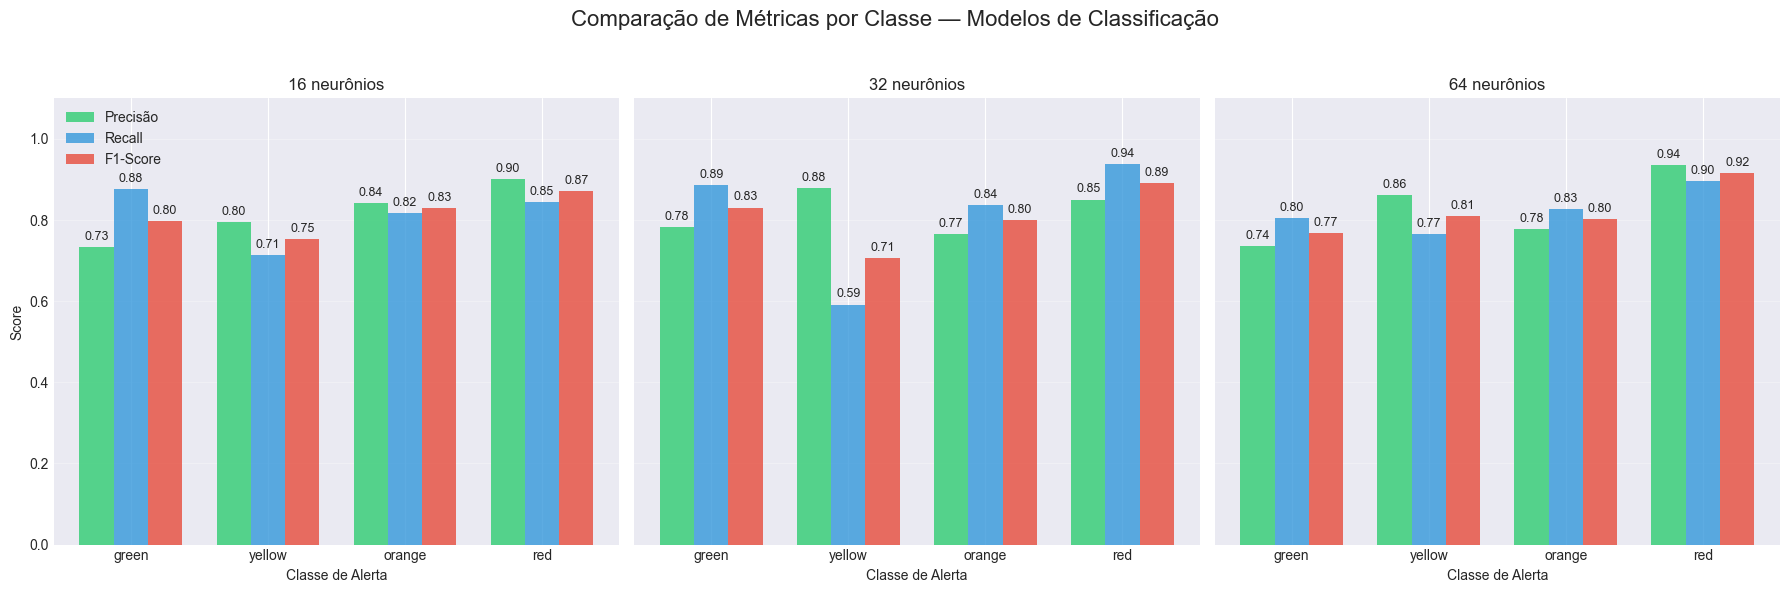

In [122]:
x = np.arange(len(labels))
width = 0.25

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (neurons, info) in zip(axes, clfs_info.items()):
    y_pred = y_pred_labels[neurons]

    precision = precision_score(y_test_labels, y_pred, labels=labels, average=None, zero_division=0)
    recall = recall_score(y_test_labels, y_pred, labels=labels, average=None, zero_division=0)
    f1 = f1_score(y_test_labels, y_pred, labels=labels, average=None, zero_division=0)

    bars1 = ax.bar(x - width, precision, width, label='Precisão', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', color='#3498db', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c', alpha=0.8)

    ax.set_title(f'{neurons} neurônios')
    ax.set_xlabel('Classe de Alerta')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('Score')
axes[0].legend()
fig.suptitle('Comparação de Métricas por Classe — Modelos de Classificação', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Matrizes de confusão

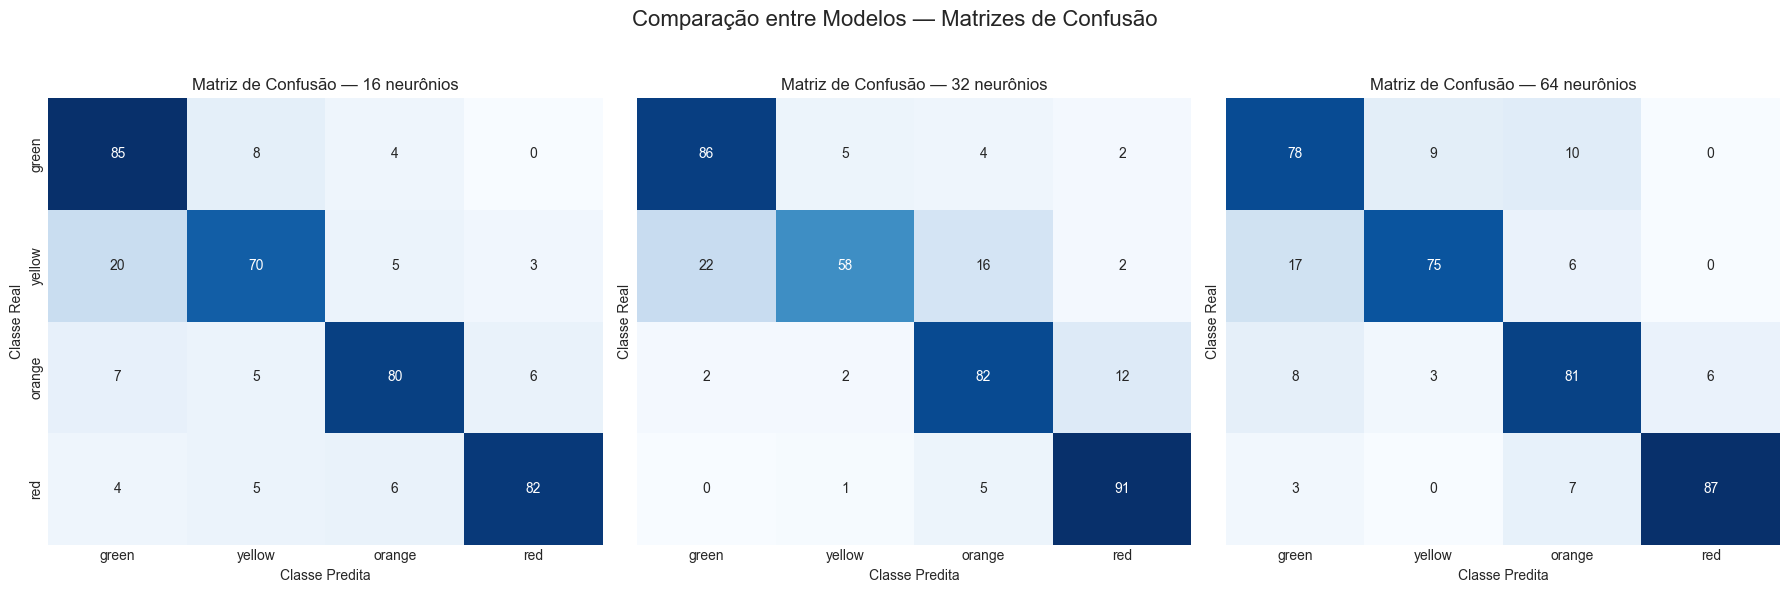

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (neurons, info) in zip(axes, clfs_info.items()):
    y_pred = y_pred_labels[neurons]

    cm = confusion_matrix(y_test_labels, y_pred, labels=labels)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar=False, ax=ax)

    ax.set_title(f'Matriz de Confusão — {neurons} neurônios')
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')

# Ajustes finais
fig.suptitle('Comparação entre Modelos — Matrizes de Confusão', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


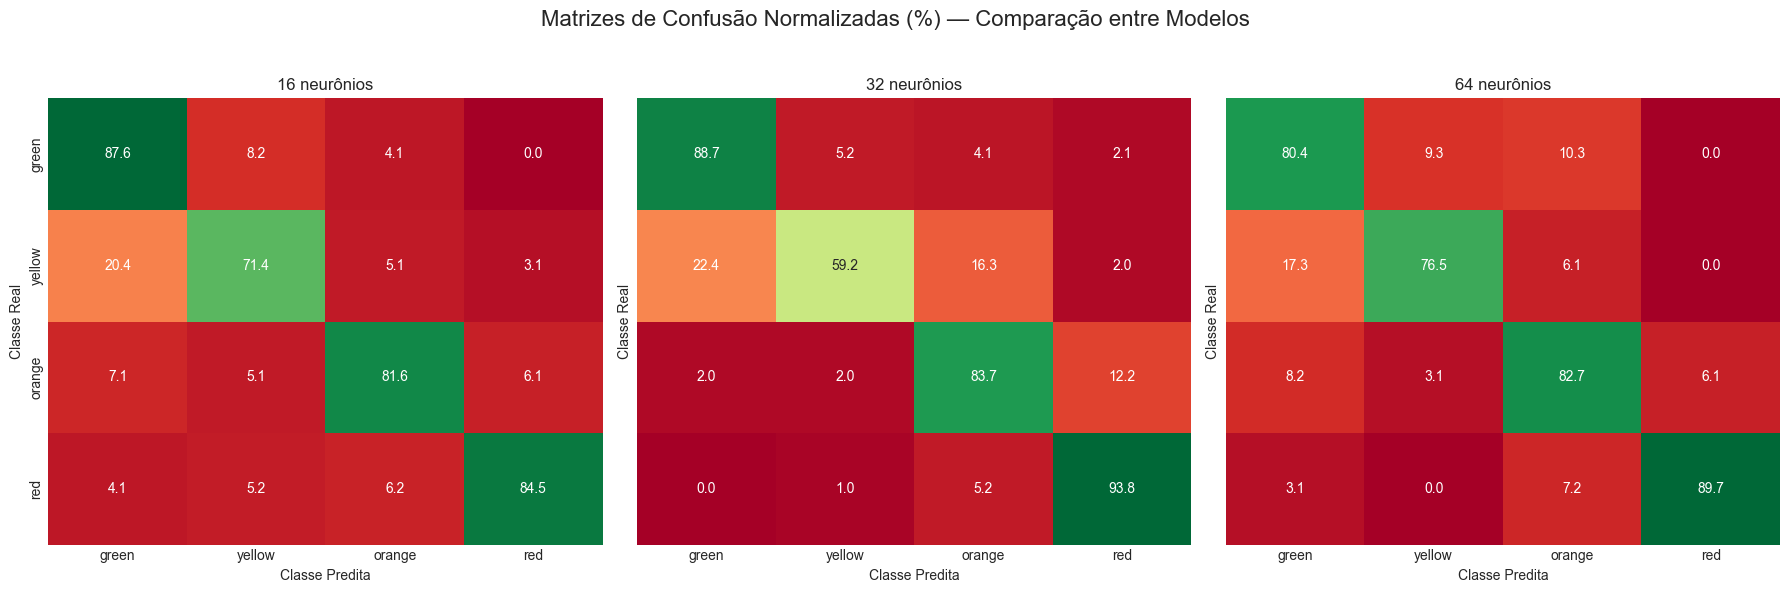

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (neurons, info) in zip(axes, clfs_info.items()):
    y_pred = y_pred_labels[neurons]

    cm = confusion_matrix(y_test_labels, y_pred, labels=labels)

    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        xticklabels=labels,
        yticklabels=labels,
        cbar=False,
        ax=ax
    )

    ax.set_title(f'{neurons} neurônios')
    ax.set_xlabel("Classe Predita")
    ax.set_ylabel("Classe Real")

fig.suptitle("Matrizes de Confusão Normalizadas (%) — Comparação entre Modelos", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Comparação de erros de classificação


MÉRICA DE ERROS - MODELO: 16 neurônios

Classe Real     Predito como    Erros      % da classe    
----------------------------------------------------------------------
yellow          green           20         20.41          %
green           yellow          8          8.25           %
orange          green           7          7.14           %
red             orange          6          6.19           %
orange          red             6          6.12           %

MÉRICA DE ERROS - MODELO: 32 neurônios

Classe Real     Predito como    Erros      % da classe    
----------------------------------------------------------------------
yellow          green           22         22.45          %
yellow          orange          16         16.33          %
orange          red             12         12.24          %
green           yellow          5          5.15           %
red             orange          5          5.15           %

MÉRICA DE ERROS - MODELO: 64 neurônios

Classe Real     P

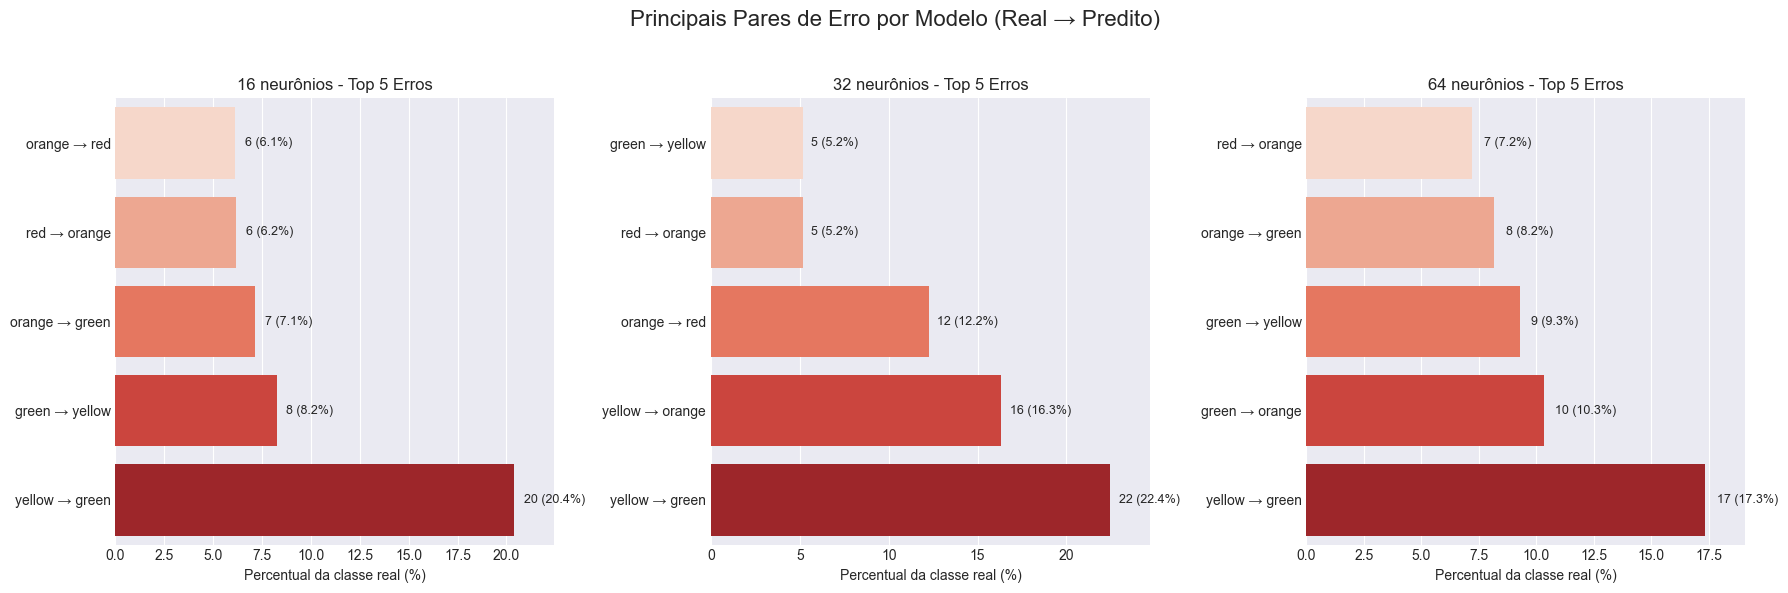

In [125]:
top_n = 5

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for ax, (neurons, info) in zip(axes, clfs_info.items()):
    y_pred = y_pred_labels[neurons]
    cm = confusion_matrix(y_test_labels, y_pred, labels=labels)

    with np.errstate(divide='ignore', invalid='ignore'):
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
        cm_normalized = np.nan_to_num(cm_normalized)

    error_pairs = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j and cm[i, j] > 0:
                error_pairs.append({
                    'Real': labels[i],
                    'Predito': labels[j],
                    'Contagem': int(cm[i, j]),
                    'Percentual': float(cm_normalized[i, j])
                })

    error_df = pd.DataFrame(error_pairs)
    if not error_df.empty:
        error_df = error_df.sort_values('Contagem', ascending=False).reset_index(drop=True)
    else:
        error_df = pd.DataFrame(columns=['Real', 'Predito', 'Contagem', 'Percentual'])

    print("\n" + "=" * 70)
    print(f"MÉRICA DE ERROS - MODELO: {neurons} neurônios")
    print("=" * 70)
    if error_df.empty:
        print("Nenhum erro encontrado para este modelo (todas as previsões corretas ou sem amostras).")
    else:
        print(f"\n{'Classe Real':<15} {'Predito como':<15} {'Erros':<10} {'% da classe':<15}")
        print("-" * 70)
        for _, row in error_df.head(top_n).iterrows():
            print(f"{row['Real']:<15} {row['Predito']:<15} {row['Contagem']:<10d} {row['Percentual']:<15.2f}%")

    ax.set_title(f'{neurons} neurônios - Top {top_n} Erros')
    if error_df.empty:
        ax.text(0.5, 0.5, 'Nenhum erro', ha='center', va='center', fontsize=12)
        ax.axis('off')
    else:
        top_df = error_df.head(top_n).copy()
        
        top_df['pair_label'] = top_df['Real'] + ' → ' + top_df['Predito']
        sns.barplot(
            x='Percentual',
            y='pair_label',
            hue='pair_label',
            data=top_df.sort_values('Percentual', ascending=True),
            ax=ax,
            palette='Reds',
            legend=False
        )
        ax.set_xlabel('Percentual da classe real (%)')
        ax.set_ylabel('')
        ax.set_xlim(0, max(top_df['Percentual'].max() * 1.1, 5))

        for i, row in enumerate(top_df.sort_values('Percentual', ascending=True).itertuples()):
            ax.text(row.Percentual + 0.5, i, f"{row.Contagem} ({row.Percentual:.1f}%)", va='center', fontsize=9)

plt.suptitle('Principais Pares de Erro por Modelo (Real → Predito)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

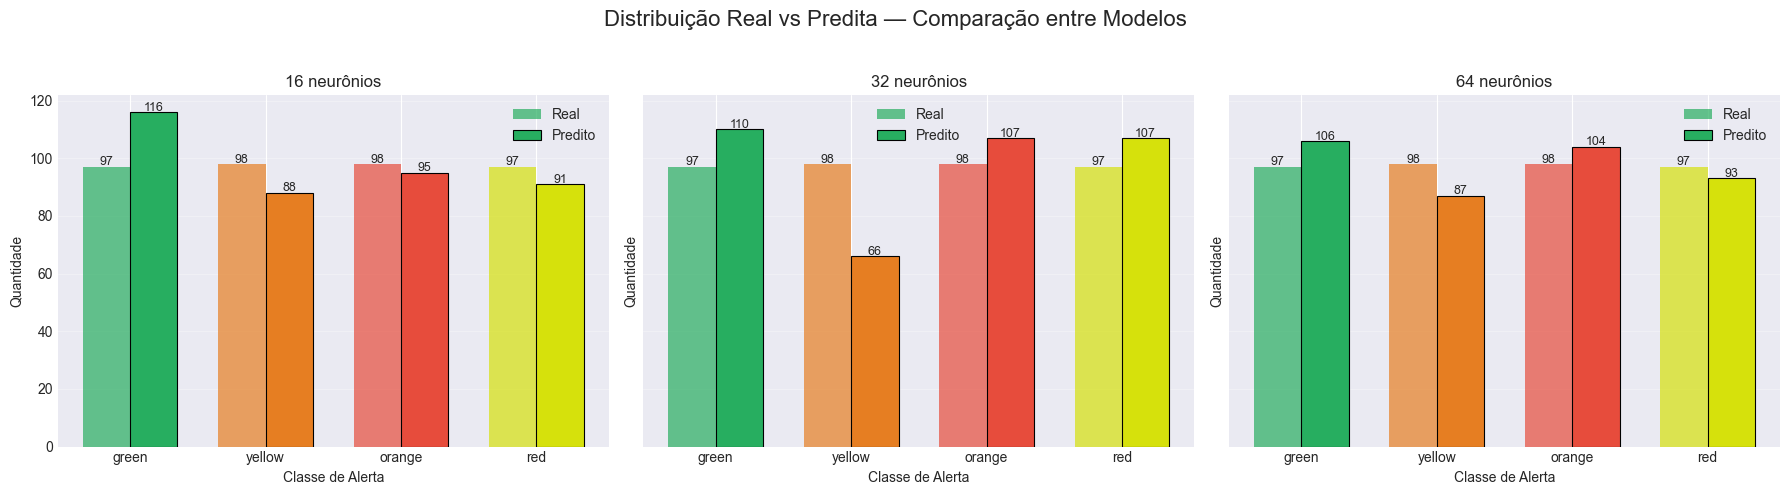

In [126]:
plt.style.use('seaborn-v0_8-darkgrid')

colors = ['#27ae60', '#e67e22', '#e74c3c', '#d6e10c']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (neurons, info) in zip(axes, clfs_info.items()):
    # Contagem real
    real_counts = pd.Series(y_test_labels).value_counts().reindex(labels, fill_value=0)

    # Contagem predita pelo modelo atual
    pred_counts = pd.Series(y_pred_labels[neurons]).value_counts().reindex(labels, fill_value=0)

    # Plot das barras
    x = range(len(labels))
    width = 0.35

    ax.bar([p - width/2 for p in x], real_counts.values, width=width,
           color=colors, alpha=0.7, label='Real')
    ax.bar([p + width/2 for p in x], pred_counts.values, width=width,
           color=colors, alpha=1.0, edgecolor='black', linewidth=0.8, label='Predito')

    # Títulos e rótulos
    ax.set_title(f'{neurons} neurônios')
    ax.set_xlabel('Classe de Alerta')
    ax.set_ylabel('Quantidade')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()

    # Anotar valores sobre as barras
    for i in range(len(labels)):
        ax.text(x[i] - width/2, real_counts.values[i] + 0.5, str(int(real_counts.values[i])),
                ha='center', fontsize=9)
        ax.text(x[i] + width/2, pred_counts.values[i] + 0.5, str(int(pred_counts.values[i])),
                ha='center', fontsize=9)

fig.suptitle('Distribuição Real vs Predita — Comparação entre Modelos', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
